# Writing a nonlinear solver #


In [1]:
from fenics import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def kappa(u):
    return 1 + u*u

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary

16.5203891327


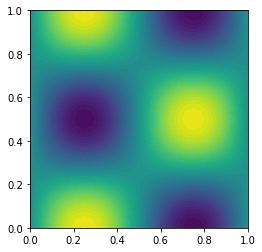

In [7]:
h = 32
p = 1

mesh = UnitSquareMesh(h, h)   # generate mesh
V = FunctionSpace(mesh, 'P', p)

x = SpatialCoordinate(mesh)

Ua = sin(2*pi*x[0]) * cos(2*pi*x[1])
Fa = - div(kappa(Ua)*grad(Ua))

bc = DirichletBC(V, Ua, boundary)

# Define Variational problem
u1 = Function(V)
v = TestFunction(V)

# it kept on asking to reduce number of points in the solver (u1 changes on 1e-6 level)
q_degree = 3
dx = dx(metadata={'quadrature_degree': q_degree})

# solve
F = kappa(u1)*inner(grad(u1), grad(v))*dx - Fa*v*dx
solve(F == 0, u1, bc)
print(np.linalg.norm(u1.vector()))
plot(u1)

# Define Variational problem 2
u2 = Function(V)
F = kappa(u2)*inner(grad(u2), grad(v))*dx - Fa*v*dx
J = derivative(F, u2)

The problems we ran into with the nonlinear solver was the BC definition

In [10]:
def nonlinear_solve(F, uh, bc, tol, max_iterations): 
    s = uh.vector()[:].copy()
    bc.apply(uh.vector())
    n_diff = tol+1
    i_count = 0
    while abs(n_diff) > tol and i_count < max_iterations:
        A = assemble(derivative(F, uh))
        b = assemble(-F)
        bc = DirichletBC(V, Constant(0.), boundary)
        bc.apply(A, b)
        solve(A, s, b)
        uh.vector()[:] += s
        n_diff = np.linalg.norm(s) 
        i_count += 1
    return uh, i_count

As you can see in our function, the trick is to set the boundary conditions at the first guess to the exact boundary conditions. Afterwards the boundary conditions of the guess $s$ is set to zero so it won't touch the values at the boundary.

The domain will be updated by the Jacobian but the boundaries are already set. 

 # of iterations:  1


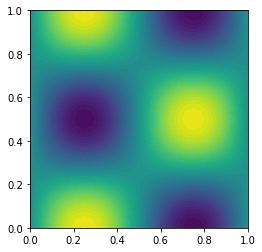

In [13]:
tol = 1e-6
max_iterations = 200
u, iter_count = nonlinear_solve(F, u2, bc, tol, max_iterations)
plot(u)
print "# of iterations: ", iter_count

Only one iteration???

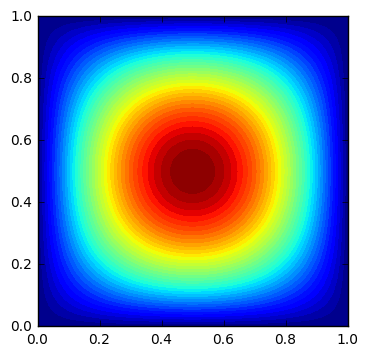

In [38]:

h = 64
mesh = UnitSquareMesh(h, h)   # generate mesh
V = FunctionSpace(mesh, 'P', 4)    # create finite element function space V, based on linear Lagrange elements
# plot(mesh)

f_exp = Expression('2*pi*pi * sin(pi*x[0]) * sin(pi*x[1])', degree=4)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary

u_D = Expression('sin(pi*x[0]) * sin(pi*x[1])', degree=4)
bc = DirichletBC(V, u_D, boundary)

u = TrialFunction(V)
v = TestFunction(V)

a = inner(grad(u), grad(v))*dx
L = f_exp * v * dx

# Compute solution
uref = Function(V)
solve(a == L, uref, bc,
      solver_parameters={'linear_solver': 'cg',
                         'preconditioner': 'petsc_amg'})
plot(uref)

In [39]:
def linear_solve(a, L, uh, bc): 
    A = assemble(a)
    b = assemble(L) 
    bc.apply(A, b) 
    x = uh.vector() 
    solve(A, x, b)
    return x

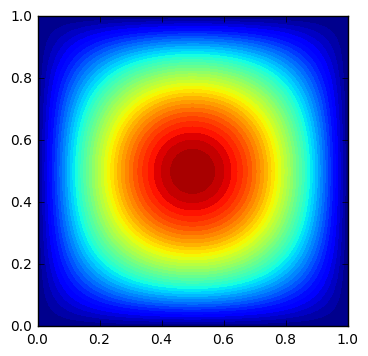

In [40]:

u = TrialFunction(V)
v = TestFunction(V)

a = inner(grad(u), grad(v))*dx
L = f_exp * v * dx

# Compute solution
uh = Function(V)
uh.vector()[:] = linear_solve(a, L, uh, bc)
plot(uh)

In [41]:
def extract_modes(A, neigs):
    solver = SLEPcEigenSolver(A)
    solver.parameters["solver"] = "krylov-schur"
    solver.parameters["problem_type"] = "gen_hermitian"
    solver.parameters["spectrum"] = "target magnitude"
    solver.parameters["spectral_transform"] = "shift-and-invert"
    solver.parameters["spectral_shift"] = 0.
    solver.solve(neigs)
    
    # Extract and plot modes
    modes=[]
    eigvalues=[]
    vtkfile = File('Modes/modes.pvd')  
    for md in range(neigs):
        r, c, rx, cx = solver.get_eigenpair(md)
        # Initialize function and assign eigenvector
        if not (r > 1.-1.e-8 and r < 1.+1.e-8):
            mode = Function(V)
            mode.rename("mode",'mode')
            mode.vector()[:] = rx
            modes.append(mode)
            eigvalues.append(r)
            # Save mode to file
            vtkfile << (mode, sqrt(r))    
            del(mode)
    return modes, eigvalues

In [42]:
def x_stat(K, F):
    return np.dot(np.linalg.inv(K), F)

In [43]:
def a_func(u, v):
    return inner(grad(u), grad(v))*dx

def L_func(v):
    return f_exp * v * dx

def modal_solve(a, L, uh, bc, neigs): 
    A = PETScMatrix()
    b = PETScVector()
    assemble_system(a, L, bc, A_tensor=A, b_tensor=b)
    modes, evs = extract_modes(A, neigs)
    nmodes = len(evs)
    M = np.zeros([nmodes,nmodes])
    K = np.zeros([nmodes,nmodes])
    F = np.zeros(nmodes)

    for i in range(nmodes):
        F[i] = assemble(L_func(modes[i]))
        for j in range(nmodes):
            K[i,j]=assemble(a_func(modes[i], modes[j]))
    
    c_0 = x_stat(K, F)
    return c_0, modes, evs

In [44]:

u = TrialFunction(V)
v = TestFunction(V)

a = inner(grad(u), grad(v))*dx
L = f_exp * v * dx

neigs=10
# Compute solution
uh = Function(V)
coeff, modes, evs = modal_solve(a, L, uh, bc, neigs)

In [45]:

u = TrialFunction(V)
v = TestFunction(V)

a = inner(grad(u), grad(v))*dx
L = f_exp * v * dx

neigs = 20
# Compute solution
uh = Function(V)
coeff, modes, evs = modal_solve(a, L, uh, bc, neigs)
A = PETScMatrix()
b = PETScVector()
assemble_system(a, L, bc, A_tensor=A, b_tensor=b)
modes, evs = extract_modes(A, neigs)
nmodes = len(evs)
M = np.zeros([nmodes,nmodes])
K = np.zeros([nmodes,nmodes])
F = np.zeros(nmodes)

for i in range(nmodes):
    F[i] = assemble(L_func(modes[i]))
    for j in range(nmodes):
        K[i,j]=assemble(a_func(modes[i], modes[j]))

c_0 = x_stat(K, F)

In [48]:
uh = c_0[0]*modes[0]

<function matplotlib.pyplot.show>

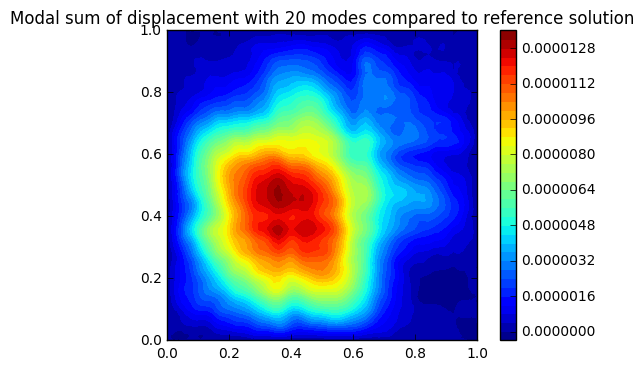

In [52]:
fig = plt.figure()
ttl="Modal sum of displacement with " + str(len(evs)) + " modes compared to reference solution"
plt.title(ttl)
modes_total = sum(c_0[:]*modes[:])
ax = plot(uref - modes_total)
cbar = plt.colorbar(ax)
plt.show

In [17]:
c_0[0]

127.9999999740394

In [53]:
(c_0[0]*modes[0])